In [ ]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('karanravindra/mnist-autoencoder/model-s8lnnp8k:v0', type='model')
# artifact_dir = artifact.download()
# run.finish()

In [2]:
import warnings
from collections import Counter

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim_func
from nn_zoo.datamodules import MNISTDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d, SelfAttention

import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")


class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(Block, self).__init__()
        self.layers = nn.ModuleList(
            [
                self._block(in_channels, out_channels)
                if i == 0
                else self._block(out_channels, out_channels)
                for i in range(num_layers)
            ]
        )

    def _block(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.GroupNorm(in_channels // 4 if in_channels >= 4 else 1, in_channels),
            nn.GELU(),
            DepthwiseSeparableConv2d(in_channels, out_channels, 3),
        )

    def forward(self, x):
        x = self.layers[0](x)
        for i, layer in enumerate(self.layers[1:]):
            x = layer(x) + x
        return x


class DownBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(DownBlock, self).__init__(
            Block(in_channels * 4, out_channels, depth),
            # nn.MaxPool2d(2)
            nn.PixelUnshuffle(2),
        )


class UpBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, depth: int):
        super(UpBlock, self).__init__()
        self.block = nn.Sequential(
            nn.PixelShuffle(2),
            # nn.Upsample(scale_factor=2, mode="nearest"),
            Block(in_channels, out_channels * 4, depth),
        )

    def forward(self, x):
        return self.block(x)


class AutoEncoder(nn.Module):
    def __init__(self, width: int, depth: int):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            Block(1, width * 4, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
            DownBlock(width, width, depth),
        )
        self.proj_in = nn.Identity()
        self.vq = nn.Identity()
        self.proj_out = nn.Identity()
        self.decoder = nn.Sequential(
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            UpBlock(width, width, depth),
            Block(width * 4, 1, depth),
            nn.Sigmoid(),
        )
        self.apply(self._init_weights)

        # self.register_module("lpips", LPIPS(net_type="squeeze", normalize=True))

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.encoder(x)
        x = self.proj_in(x)
        if isinstance(self.vq, nn.Identity):
            x = self.vq(x)
        else:
            x, *_ = self.vq(x)
        x = self.proj_out(x)
        x = self.decoder(x)

        return x

    # @staticmethod
    def loss(self, x, y):
        mse = F.mse_loss(x, y)
        bce = F.binary_cross_entropy(x, y)
        psnr = 10 * (1 / mse).log10()
        ssim = ssim_func(x, y)
        # lpips = self.lpips(x.repeat(1, 3, 1, 1), y.repeat(1, 3, 1, 1))

        return {
            "loss": bce, # + lpips,
            "bce": bce,
            "mse": mse,
            "ssim": ssim,
            "psnr": psnr,
            # "lpips": lpips,
        }

In [4]:
ae = AutoEncoder(width=4, depth=2)
state_dict=torch.load('../mnist-autoencoder/jg8jxsd2/checkpoints/epoch=29-step=28140.ckpt', map_location=torch.device('cpu'))['state_dict']
err = ae.load_state_dict(dict(map(lambda x: (x[0].replace("model.", ""), x[1]), state_dict.items())), strict=False)
# ae.lpips = None
ae = ae.to("mps")
print(err)

ae.eval()
for param in ae.parameters():
    param.requires_grad = False

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lpips.net.net.slices.0.0.weight', 'lpips.net.net.slices.0.0.bias', 'lpips.net.net.slices.1.3.squeeze.weight', 'lpips.net.net.slices.1.3.squeeze.bias', 'lpips.net.net.slices.1.3.expand1x1.weight', 'lpips.net.net.slices.1.3.expand1x1.bias', 'lpips.net.net.slices.1.3.expand3x3.weight', 'lpips.net.net.slices.1.3.expand3x3.bias', 'lpips.net.net.slices.1.4.squeeze.weight', 'lpips.net.net.slices.1.4.squeeze.bias', 'lpips.net.net.slices.1.4.expand1x1.weight', 'lpips.net.net.slices.1.4.expand1x1.bias', 'lpips.net.net.slices.1.4.expand3x3.weight', 'lpips.net.net.slices.1.4.expand3x3.bias', 'lpips.net.net.slices.2.6.squeeze.weight', 'lpips.net.net.slices.2.6.squeeze.bias', 'lpips.net.net.slices.2.6.expand1x1.weight', 'lpips.net.net.slices.2.6.expand1x1.bias', 'lpips.net.net.slices.2.6.expand3x3.weight', 'lpips.net.net.slices.2.6.expand3x3.bias', 'lpips.net.net.slices.2.7.squeeze.weight', 'lpips.net.net.slices.2.7.squeeze.bias', 'lpips.net.net.s

In [5]:
# dm = MNISTDataModule(
#         data_dir="../../data",
#         dataset_params={
#             "download": True,
#             "transform": torchvision.transforms.Compose(
#                 [
#                     torchvision.transforms.Resize((32, 32)),
#                     torchvision.transforms.ToTensor(),
#                 ]
#             ),
#         },
#         loader_params={
#             "batch_size": 128,
#         },
#     )

# dm.setup()

# train_loader = dm.train_dataloader()
# val_loader = dm.val_dataloader()

In [6]:
# latents = []
# y_true = []

# with torch.no_grad():
#     ae.eval()
#     for x, y in train_loader:
#         x = x.to("mps")
#         x = ae.encoder(x)
#         x = ae.proj_in(x)
#         if isinstance(ae.vq, nn.Identity):
#             x = ae.vq(x)
#         else:
#             x, *_ = ae.vq(x)
#         latents.append(x)
#         y_true.append(y)

#     latents = torch.cat(latents, dim=0).cpu()
#     y_true = torch.cat(y_true, dim=0).cpu()

#     train_dataset = torch.utils.data.TensorDataset(latents, y_true)
#     torch.save(train_dataset, "train_dataset.pt")

# latents = []
# y_true = []

# with torch.no_grad():
#     ae.eval()
#     for x, y in val_loader:
#         x = x.to("mps")
#         x = ae.encoder(x)
#         x = ae.proj_in(x)
#         if isinstance(ae.vq, nn.Identity):
#             x = ae.vq(x)
#         else:
#             x, *_ = ae.vq(x)
#         latents.append(x)
#         y_true.append(y)

#     latents = torch.cat(latents, dim=0).cpu()
#     y_true = torch.cat(y_true, dim=0).cpu()

#     val_dataset = torch.utils.data.TensorDataset(latents, y_true)
#     torch.save(val_dataset, "val_dataset.pt")

In [7]:
train_dataset = torch.load("train_dataset.pt")
val_dataset = torch.load("val_dataset.pt")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [38]:
from torchinfo import summary
from nn_zoo.models.components import DepthwiseSeparableConv2d, SelfAttention
from einops import rearrange

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList(
            [SelfAttention(embed_dim, embed_dim // num_heads) for _ in range(num_heads)]
        )
        self.fc = nn.Linear(embed_dim * num_heads, embed_dim)

    def forward(self, x):
        x = torch.cat([head(x, is_causal=False) for head in self.heads], dim=-1)
        x = self.fc(x)
        return x
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, m: int):
        super(TransformerBlock, self).__init__()
        self.ln1 = nn.Identity()# nn.LayerNorm(embed_dim)
        self.ln2 = nn.Identity()# nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * m),
            nn.GELU(),
            nn.Linear(embed_dim * m, embed_dim),
        )

        self.c_mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
        )
    

    def forward(self, x, t, y):
        c = self.c_mlp(t + y)
        x = x + self.attn(c * self.ln1(x) + c) * c
        x = x + self.mlp(c * self.ln2(x) + c) * c
        return x
    
class Model(nn.Module):
    def __init__(self, embed_dim: int = 16, num_heads: int = 4, m: int = 4):
        super(Model, self).__init__()

        self.up_ln = nn.GroupNorm(1, 16)
        self.up = DepthwiseSeparableConv2d(16, embed_dim, 1, padding=0)
        
        self.block1 = TransformerBlock(embed_dim, num_heads, m)
        self.block2 = TransformerBlock(embed_dim, num_heads, m)
        self.block3 = TransformerBlock(embed_dim, num_heads, m)
        
        self.down_ln = nn.GroupNorm(1, embed_dim)
        self.down = DepthwiseSeparableConv2d(embed_dim, 16, 1, padding=0)
        
        self.t_emb = nn.Embedding(1000, embed_dim)
        self.y_emb = nn.Embedding(10, embed_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, 16, 1))

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, 0, 0.02)

    def forward(self, x, t=0, y=0):
        if isinstance(t, int):
            t = torch.full((x.shape[0], 1), t, device=x.device)
        if isinstance(y, int):
            y = torch.full((x.shape[0], 1), y, device=x.device)

        t = self.t_emb(t).view(t.shape[0], 1, -1)
        y = self.y_emb(y).view(t.shape[0], 1, -1) + self.pos_emb
        
        x = self.up_ln(x)
        x = self.up(x)

        x = rearrange(x, "b c h w -> b (h w) c") + self.pos_emb

        x = self.block1(x, t, y)
        x = self.block2(x, t, y)
        x = self.block3(x, t, y)

        x = rearrange(x, "b (h w) c -> b c h w", h=4, w=4)

        x = self.down_ln(x)
        x = self.down(x)
        
        return x



    
model = Model().to("mps")
# print(model(torch.randn(1, embed_dim, 4, 4, device="mps"), 1, 1).shape)
summary(model, input_size=(512, 16, 4, 4), device="mps", depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [512, 16, 4, 4]           16
├─Embedding: 1-1                         [512, 1, 16]              16,000
├─Embedding: 1-2                         [512, 1, 16]              160
├─GroupNorm: 1-3                         [512, 16, 4, 4]           32
├─DepthwiseSeparableConv2d: 1-4          [512, 16, 4, 4]           --
│    └─DepthwiseConv2d: 2-1              [512, 16, 4, 4]           32
│    └─Conv2d: 2-2                       [512, 16, 4, 4]           272
├─TransformerBlock: 1-5                  [512, 16, 16]             --
│    └─Sequential: 2-3                   [512, 16, 16]             544
│    └─Identity: 2-4                     [512, 16, 16]             --
│    └─MultiHeadAttention: 2-5           [512, 16, 16]             5,392
│    └─Identity: 2-6                     [512, 16, 16]             --
│    └─Sequential: 2-7                   [512, 16, 16]             2,128
├─

In [39]:
from tqdm import tqdm
from ema_pytorch import EMA
from diffusers import DDIMScheduler

ddim = DDIMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=500, verbose=True)
ema = EMA(model, beta=0.999, update_after_step=500, update_every=10)

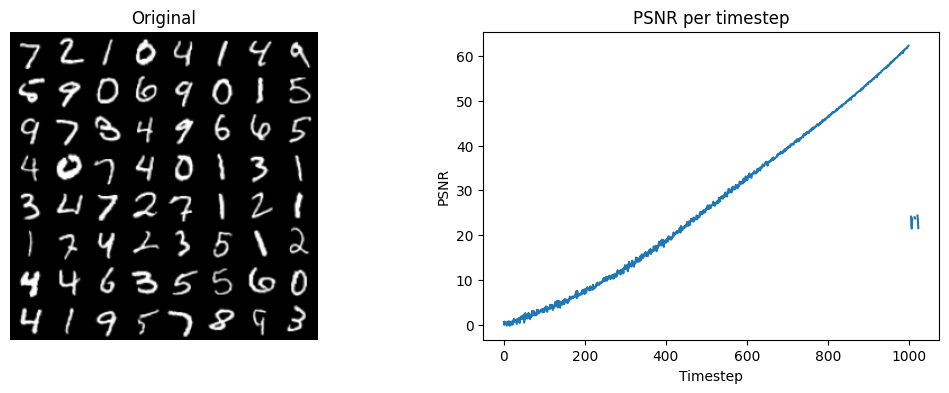

In [40]:
x, y = next(iter(val_loader))
x, y = x.to("mps"), y.to("mps")

# x, y = x[], y[]
x, y = x.repeat(4, 1, 1, 1), y.repeat(4)

output = ae.decoder(ae.vq(ae.proj_out(x[:64])))
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(torchvision.utils.make_grid(output, nrow=8).cpu().detach().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 2)
# plot psnr per timestep
ts = []
psnrs = []
stds = []
noise = torch.randn_like(x)
for t in range(0, 1000, x.shape[0]):
    t = torch.arange(t, t + x.shape[0], device="cpu")
    noisy_x = ddim.add_noise(x, noise, t)

    mse = (noise - noisy_x).pow(2)    
    mse = mse.view(mse.shape[0], -1).mean(1)

    psnr = 10 * (1 / mse).log10()
    
    ts.append(t)
    psnrs.append(psnr)
    stds.append(noisy_x.std().item())

ts = torch.cat(ts)[:1000]
psnrs = torch.cat(psnrs)[:1000]
# stds = torch.cat(stds)

plt.plot(ts.cpu(), psnrs.cpu())
plt.xlabel("Timestep")
plt.ylabel("PSNR")
plt.title("PSNR per timestep")

plt.show()

In [41]:
roll_loss = 0.5

model.train()
pbar = tqdm(range(10000), ncols=100, desc="Training", unit="step")
for i in pbar:
    t = torch.randint(0, 1000, (x.shape[0],), device=x.device)
    noise = torch.randn_like(x, device=x.device)
        
    x_noisy = ddim.add_noise(x, noise, t)
    y_pred = model(x_noisy, t, y)
    loss = F.mse_loss(y_pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ema.update()
    roll_loss = 0.9 * roll_loss + 0.1 * loss.item()
    pbar.set_postfix_str(f"mse={roll_loss:.4f}, std={(noise - y_pred).std().item():.4f}, lr={scheduler.get_last_lr()[0]:.1e}")
    scheduler.step(loss)
    # break

Training: 100%|█████████| 10000/10000 [06:51<00:00, 24.32step/s, mse=0.0119, std=0.1105, lr=2.4e-07]


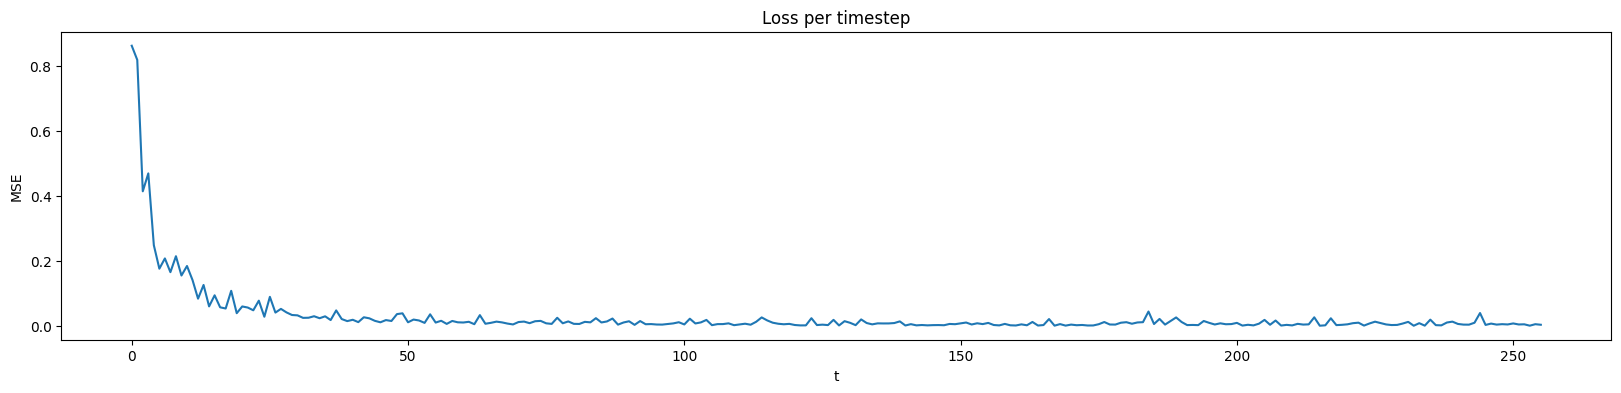

In [36]:
# for t 0, 1000 calculate loss
steps = []
losses = []

model.eval()
with torch.no_grad():
    for t in range(0, 100, x.shape[0]):
        t = torch.arange(t, t + x.shape[0], device=x.device).view(-1, 1)
        noise = torch.randn_like(x, device=x.device)
        
        x_noisy = ddim.add_noise(x, noise, t)
        y_pred = model(x_noisy, t, y)
        loss = (y_pred - noise).pow(2)
        
        # sum loss per image
        loss = loss.view(loss.shape[0], -1).mean(1)
        
        steps.append(t.flatten().cpu())
        losses.append(loss.cpu())

steps = torch.cat(steps, dim=0)
losses = torch.cat(losses, dim=0)

plt.figure(figsize=(20, 4))
plt.title("Loss per timestep")
plt.plot(steps, losses)
plt.xlabel("t")
plt.ylabel("MSE")
# plt.yscale("log")

plt.show()

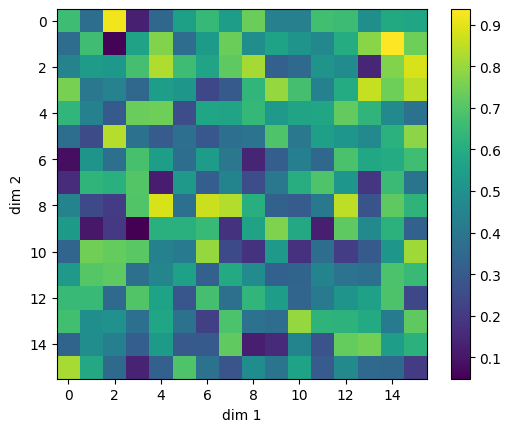

In [37]:
plt.imshow(model.pos_emb.cpu().detach().sigmoid().numpy().squeeze())
plt.colorbar()
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.show()

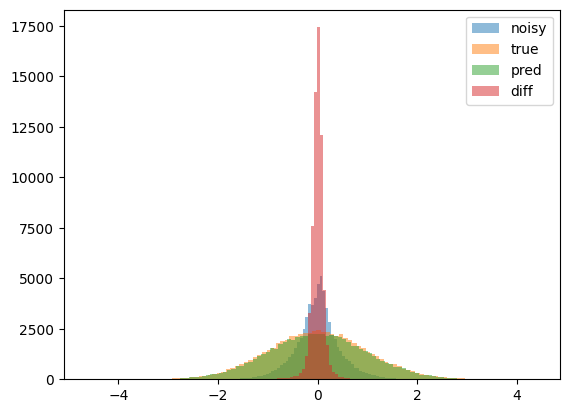

In [31]:
plt.hist(x_noisy.cpu().numpy().flatten(), bins=100, alpha=0.5, label="noisy")
plt.hist(noise.cpu().numpy().flatten(), bins=100, alpha=0.5, label="true")
plt.hist(y_pred.cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label="pred")
plt.hist((noise-y_pred).cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label="diff")
plt.legend()

In [ ]:
for name, param in model.named_parameters():
    grads = 0
    if param.grad is not None:
        print(f"{name}: {param.grad.norm().item():.2e}")
        grads += param.grad.norm().item()
print(grads / len(list(model.named_parameters())))

In [ ]:
@torch.no_grad()
def generate(eta, steps, model):
    ddim.num_inference_steps = steps
    x = torch.randn((110, 16, 4, 4), device="mps")
    y = torch.randint(0, 11, (110,), device="mps")
    
    for i in reversed(range(0, 1000, 1000 // steps)):
        noise_pred = model(x, torch.full((110, 1), i, device="mps"), y)
        x = ddim.step(noise_pred, i, x, eta=eta).prev_sample
        
    x = ae.decoder(ae.vq(ae.proj_out(x)))
    print(x.shape)
    return x


grid = torchvision.utils.make_grid(generate(1, 100, model).cpu(), nrow=11)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()